<a href="https://colab.research.google.com/github/rcarrata/lpic-vagrant/blob/master/2_HyperParameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Exercise 0 - LOADING DATASET

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/Colab/Insurance/insurance.csv"

root_folder = "/content/drive/My Drive/Colab/"
project_folder = "Insurance/"
csv_file = "insurance.csv"

csv_data = root_folder + project_folder + csv_file
print(csv_data)

dataset = pd.read_csv(csv_data)

from google.colab.data_table import DataTable
DataTable.max_columns = 60

dataset.head()



Mounted at /content/drive
'/content/drive/My Drive/Colab/Insurance/insurance.csv'
/content/drive/My Drive/Colab/Insurance/insurance.csv


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
## EXERCISE 0 - Desing Model Functions

import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam


# For reproducibility of result we always use the same seed for random number generator
# Operations that rely on a random seed actually derive it from two seeds: the global and operation-level seeds. This sets the global seed.
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(42) 

# Already imported in the step before
#dataset = pd.read_csv("insurance.csv") 
dataset.to_csv("test.csv", index = False)

# Function to design the model
def design_model(X, learning_rate):  
    model = Sequential(name="my_first_model")
    input = tf.keras.Input(shape=(X.shape[1],))
    model.add(input)
    # Adding one hidden layer
    model.add(layers.Dense(64, activation='relu')) 
    model.add(layers.Dense(1))
    # --> Setting the learning rate of Adam to the one specified in the function parameter <--
    opt = Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model

    # In the case of regression, the most often used loss function is the Mean 
    # Squared Error mse (the average squared difference between the estimated values and
    # the actual value). Additionally, we want to observe the progress of the Mean 
    # Absolute Error ( mae ) while training the model
    # because MAE can give us a better idea than mse on
    # how far off we are from the true values in the units we
    # are predicting.

features = dataset.iloc[:,0:6] #choose first 7 columns as features
labels = dataset.iloc[:,-1] #choose the final column for prediction
features = pd.get_dummies(features) #one hot encoding for categorical variables
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)

#standardize
ct = ColumnTransformer([('standardize', StandardScaler(), ['age', 'bmi', 'children'])], remainder='passthrough')
features_train = ct.fit_transform(features_train) # Gives numpy arrays
features_test = ct.transform(features_test) # Gives numpy arrays




# THEORY 1 - Using a validation set for hyperparameter tuning

* Using the *training data to choose hyperparameters might lead to overfitting to the training data meaning the model learns patterns* specific to the training data that would not apply to new data. 

* For that reason, **hyperparameters are chosen on a held-out set called validation set.**

* In TensorFlow Keras, **validation split can be specified** as a parameter in the **.fit()** function:

```python
my_model.fit(data, labels, epochs = 20, batch_size = 1, verbose = 1,  validation_split = 0.2)
```

 where validation_split is a float between 0 and 1, denoting a fraction of the training data to be used as validation data. 

* In the example above, 20% of the data would be allocated for validation. It is usually a small fraction of the training data.

* The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.

In [ ]:
# EXERCISE 1 - Using a validation set for hyperparameter tuning

model = design_model(features_train, learning_rate = 0.01)

# activate verbose to see output
model.fit(features_train, labels_train, epochs = 40, batch_size = 8, verbose = 0, validation_split = 0.33)

# THEORY 2 - Manual tuning: learning rate

* Neural networks are trained with the **gradient descent algorithm** and one of the most important hyperparameters in the network training is the **learning rate**. 

* The **learning rate** determines *how big of a change you apply to the network weights as a consequence of the error gradient calculated on a batch of training data*.

* A *larger learning rate leads to a faster learning process at a cost to be stuck in a suboptimal solution* (local minimum). 
 * A **smaller learning rate** might produce a good suboptimal or global solution, but it will take it much longer to converge. 
 * In the extremes, a **learning rate too large** will lead to an unstable learning process oscillating over the epochs. 
 * A **learning rate too small** may not converge or get stuck in a local minimum.

* *It can be helpful to test different learning rates as we change our hyperparameters.* A learning rate of 1.0 leads to oscillations, 0.01 may give us a good performance, while 1e-07 is too small and almost nothing is learned within the allotted time.

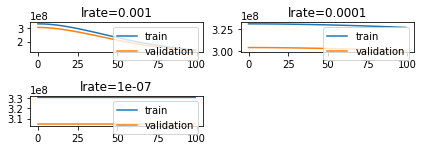

See the plot on the right with learning rates [0.001, 0.0001, 1e-07]


<Figure size 432x288 with 0 Axes>

In [ ]:
# EXERCISE 2 - Manual tuning: learning rate

#see model.py file for more details
#from model import design_model, features_train, labels_train 
import matplotlib.pyplot as plt

def fit_model(f_train, l_train, learning_rate, num_epochs, bs):
    #build the model
    model = design_model(f_train, learning_rate)
    #train the model on the training data
    history = model.fit(f_train, l_train, epochs = num_epochs, batch_size = bs, verbose = 0, validation_split = 0.2)
    # plot learning curves
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('lrate=' + str(learning_rate))
    plt.legend(loc="upper right")


# --> Change the learning rates
# make a list of learning rates to try out
# learning_rates = [1, 1E-2, 1E-7]
learning_rates = [1E-3, 1E-4, 1E-7]

#fixed number of epochs
num_epochs = 100
#fixed number of batches
batch_size = 10 

for i in range(len(learning_rates)):
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)
  fit_model(features_train, labels_train, learning_rates[i], num_epochs, batch_size)

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/My Drive/Colab/Insurance/static.png')
print("See the plot on the right with learning rates", learning_rates)


# THEORY 3 - Manual tuning: batch size

* The **batch size** is a *hyperparameter that determines how many training samples are seen before updating the network’s parameters* (weight and bias matrices).

 * ***When the batch contains all the training examples***, the process is called **batch gradient descent.** 
 * ***If the batch has one sample***, it is called the **stochastic gradient descent**.  
 * And finally, ***when 1 < batch size < number of training points***, is called **mini-batch gradient descent**. 
 * An advantage of using batches is for GPU computation that can parallelize neural network computations.

#### How do we choose the batch size for our model? 

* On one hand, a **larger batch** size will provide our model with better gradient estimates and a solution close to the optimum, but this comes at a cost of computational efficiency and good generalization performance. 

* On the other hand, **smaller batch** size is a poor estimate of the gradient, but the learning is performed faster. Finding the “sweet spot” depends on the dataset and the problem, and can be determined through hyperparameter tuning.



Learning rate fixed to: 0.1
See the plot on the right with learning rates [0.001, 0.0001, 1e-07]


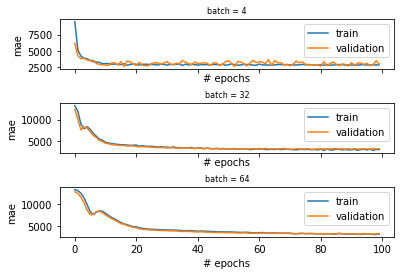

In [ ]:
# EXERCISE 3 - Manual tuning: batch size

# For this experiment, we fix the learning rate to 0.01 and try the following 
# batch sizes: 1, 2, 10, and 16. Notice how small batch sizes have a larger 
# variance (more oscillation in the learning curve).

# Want to improve the performance with a larger batch size? A good trick 
# is to increase the learning rate!

# 1. Modify the batches list to include the following batch sizes: 4, 32, 64. 
# Rerun the code and observe the plots.

# 2.In the previous checkpoint, you might have noticed bad performance for 
# larger batch sizes (32 and 64). When having performance issues with larger 
# batches it might help to increase the learning rate. Modify the value for the 
# learning rate by assigning 0.1 to the learning_rate variable. 
# Rerun the code and observe the plots.

# **loss** denotes the measure of learning success and the lower the loss the 
# better the performance. In the case of regression, the most often used loss 
# function is the **Mean Squared Error** mse 
# (the average squared difference between the estimated values and the actual value).

# Mean Absolute Error (mae) while training the model because MAE can give us a 
# better idea than mse on how far off we are from the true values in the units we are predicting.

#from model import design_model, features_train, labels_train 
import matplotlib.pyplot as plt

def fit_model(f_train, l_train, learning_rate, num_epochs, batch_size, ax):
    model = design_model(features_train, learning_rate)
    #train the model on the training data
    history = model.fit(features_train, labels_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_split = 0.3)
    # plot learning curves
    ax.plot(history.history['mae'], label='train')
    ax.plot(history.history['val_mae'], label='validation')
    ax.set_title('batch = ' + str(batch_size), fontdict={'fontsize': 8, 'fontweight': 'medium'})
    ax.set_xlabel('# epochs')
    ax.set_ylabel('mae')
    ax.legend()

#fixed learning rate 
learning_rate = 0.1 
#fixed number of epochs
num_epochs = 100
#we choose a number of batch sizes to try out
batches = [4, 32, 64] 
print("Learning rate fixed to:", learning_rate)

#plotting code
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.7, 'wspace': 0.4}) #preparing axes for plotting
axes = [ax1, ax2, ax3]

#iterate through all the batch values
for i in range(len(batches)):
  fit_model(features_train, labels_train, learning_rate, num_epochs, batches[i], axes[i])

plt.savefig('/content/drive/My Drive/Colab/Insurance/static2.png')
print("See the plot on the right with learning rates", learning_rates)


# THEORY 4 - Manual tuning: epochs and early stopping

* Being an iterative process, *gradient descent iterates many times through the training data*. 

* **The number of epochs is a hyperparameter representing the number of complete passes through the training dataset.** This is typically a large number (100, 1000, or larger). 

* If the data is split into batches, in one epoch the optimizer will see all the batches.

### How do you choose the number of epochs? 

* **Too many epochs** can lead to ***overfitting***, and **too few** to ***underfitting***. 
* One trick is to use early stopping: when the training performance reaches the plateau or starts degrading, the learning stops.

* We can specify early stopping in TensorFlow with Keras by creating an **EarlyStopping callback** and adding it as a parameter when we fit our model.

```python
from tensorflow.keras.callbacks import EarlyStopping
 
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
 
history = model.fit(features_train, labels_train, epochs=num_epochs, batch_size=16, verbose=0, validation_split=0.2, callbacks=[stop])
```

Here, we include the following:

* *monitor* = val_loss, which means we are monitoring the validation loss to decide when to stop the training
* *mode* = min, which means we seek minimal loss
* *patience* = 40, which means that if the learning reaches a plateau, it will continue for 40 more epochs in case the plateau leads to improved performance

Epoch 72: early stopping
Final training MAE: 2890.130126953125
Final validation MAE: 2961.77685546875


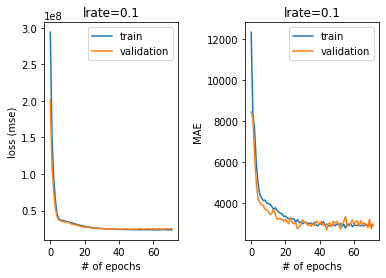

In [ ]:
# EXERCISE 4 - Manual tuning: epochs and early stopping

# 1. In the fit_model() method, just before calling model.fit(), create an instance
# of EarlyStopping that monitors the validation loss (val_loss), seeks minimal 
# loss, that is verbose, and has patience equal to 20. 
# Assign the result to a variable called es

# 2. Now that you have an instance of EarlyStopping assigned to es, you need to 
# pass the instance as a callback function to the .fit() method. We left an empty 
# list for you there: callback = []. Put es as a single element in the callback. 
# Run the code. The early stopping epoch should be 47. Please verify. 

# from model import features_train, labels_train, design_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

def fit_model(f_train, l_train, learning_rate, num_epochs):
    #build the model: to see the specs go to model.pyl we increased the number of hidden neurons
    #in order to introduce some overfitting
    model = design_model(features_train, learning_rate) 
    #train the model on the training data
    #your code here
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
    history = model.fit(features_train, labels_train, epochs=num_epochs, batch_size= 16, verbose=0, validation_split = 0.2, callbacks = [es])
    return history

    
#using the early stopping in fit_model
learning_rate = 0.1
num_epochs = 500
history = fit_model(features_train, labels_train, learning_rate, num_epochs)

#plotting
fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.5}) 
(ax1, ax2) = axs
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='validation')
ax1.set_title('lrate=' + str(learning_rate))
ax1.legend(loc="upper right")
ax1.set_xlabel("# of epochs")
ax1.set_ylabel("loss (mse)")

ax2.plot(history.history['mae'], label='train')
ax2.plot(history.history['val_mae'], label='validation')
ax2.set_title('lrate=' + str(learning_rate))
ax2.legend(loc="upper right")
ax2.set_xlabel("# of epochs")
ax2.set_ylabel("MAE")

print("Final training MAE:", history.history['mae'][-1])
print("Final validation MAE:", history.history['val_mae'][-1])

plt.savefig('/content/drive/My Drive/Colab/Insurance/static3.png')

# THEORY 5 - Manual tuning: changing the model

We saw in the previous exercise that if you have a big model and you train too long, you might overfit. Let us see the opposite - having a too simple model.

In the code on the right, we compare a one-layer neural network and a model with a single hidden layer. The models look like this:

```python
def one_layer_model(X, learning_rate):
   ...
   model.add(input) 
   model.add(layers.Dense(1))
   ...
```

and

```python
def more_complex_model(X, learning_rate):
    ...
    model.add(input)
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
```

* If you observe Plot #1 for the model with no hidden layers you will see an issue: the validation curve is below the training curve. 

* *This means that the training curve can get better at some point, but the model complexity doesn’t allow it*. This phenomenon is called **underfitting**. 
* You can also notice that no early stopping occurs here since the performance of this model is bad all the time.

* Plot #2 is for the model with a single hidden layer. You can observe a well-behaving curve with the early stopping at epoch 38 and we have a much better result. Nice!

* How do we **choose the number of hidden layers and the number of units per layer**? That is a tough question and there is no good answer. 

* The rule of thumb is to *start with one hidden layer and add as many units as we have features in the dataset*. However, this might not always work. We need to try things out and observe our learning curve.



Results of a one layer model:
Final training MAE: 7390.29052734375
Final validation MAE: 7081.5712890625
Results of a model with hidden layers:
Epoch 47: early stopping
Final training MAE: 2917.90380859375
Final validation MAE: 3213.3427734375


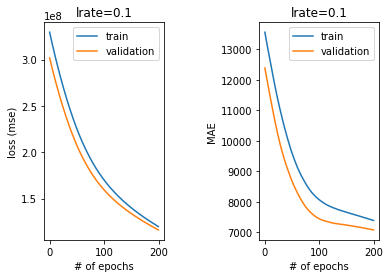

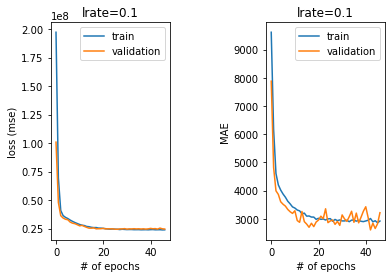

In [ ]:
# EXERCISE 5 - Manual tuning: changing the model

# Decrease the number of hidden units of the model from 64 to 8 in the 
# more_complex_model() method. When does the early stopping happen?

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def more_complex_model(X, learning_rate):
    model = Sequential(name="my_first_model")
    input = tf.keras.Input(shape=(X.shape[1],))
    model.add(input)
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model

def one_layer_model(X, learning_rate):
    model = Sequential(name="my_first_model")
    input = tf.keras.Input(shape=(X.shape[1],))
    model.add(input)
    model.add(layers.Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model

def fit_model(model, f_train, l_train, learning_rate, num_epochs):
    #train the model on the training data
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
    history = model.fit(features_train, labels_train, epochs=num_epochs, batch_size= 2, verbose=0, validation_split = 0.2, callbacks = [es])
    return history

def plot(history):
    # plot learning curves
    fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.8}) 
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.set_title('lrate=' + str(learning_rate))
    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss (mse)")

    ax2.plot(history.history['mae'], label='train')
    ax2.plot(history.history['val_mae'], label='validation')
    ax2.set_title('lrate=' + str(learning_rate))
    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("MAE")
    print("Final training MAE:", history.history['mae'][-1])
    print("Final validation MAE:", history.history['val_mae'][-1])

learning_rate = 0.1
num_epochs = 200

#fit the more simple model
print("Results of a one layer model:")
history1 = fit_model(one_layer_model(features_train, learning_rate), features_train, labels_train, learning_rate, num_epochs)
plot(history1)
plt.savefig('/content/drive/My Drive/Colab/Insurance/static4.png')

#fit the more complex model
print("Results of a model with hidden layers:")
history2 = fit_model(more_complex_model(features_train, learning_rate), features_train, labels_train, learning_rate, num_epochs)
plot(history2)
plt.savefig('/content/drive/My Drive/Colab/Insurance/static5.png')


# THEORY 6 - Towards automated tuning: grid and random search

* So far we’ve been manually setting and adjusting hyperparameters to train and evaluate our model. If we didn’t like the result, we changed the hyperparameters to some other values. 

* However, this is rather cumbersome; it would be nice if we could make these changes in a systematic and automated way. Fortunately, there are some strategies for automated hyperparameter tuning, including the following two.

* ***Grid search***, or **exhaustive search, tries every combination of desired hyperparameter values**. 

* If, for example, we want to try learning rates of 0.01 and 0.001 and batch sizes of 10, 30, and 50, grid search will try six combinations of parameters (0.01 and 10, 0.01 and 30, 0.01 and 50, 0.001 and 10, and so on). This obviously gets very computationally demanding when we increase the number of values per hyperparameter or the number of hyperparameters we want to tune.

* On the other hand, ***Random Search*** **goes through random combinations of hyperparameters and doesn’t try them all**.

## Grid search in Keras

* To use GridSearchCV from scikit-learn for regression we need to first wrap our neural network model into a KerasRegressor:

```python
model = KerasRegressor(build_fn=design_model)
```

* Then we need to setup the desired hyperparameters grid (we don’t use many values for the sake of speed):

```python
batch_size = [10, 40]
epochs = [10, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
```

Finally, we initialize a GridSearchCV object and fit our model to the data:

```python
grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring = make_scorer(mean_squared_error, greater_is_better=False))
grid_result = grid.fit(features_train, labels_train, verbose = 0)
```

* Notice that we initialized the scoring parameter with scikit-learn’s .**make_scorer() method**. We’re evaluating our hyperparameter combinations with a mean squared error making sure that greater_is_better is set to False since we are searching for a set of hyperparameters that yield us the smallest error.

## Randomized search in Keras

* We first change our hyperparameter grid specification for the randomized search in order to have more options:

```python
param_grid = {'batch_size': sp_randint(2, 16), 'nb_epoch': sp_randint(10, 100)}
```

* **Randomized search** will sample values for batch_size and nb_epoch from uniform distributions in the interval [2, 16] and [10, 100], respectively, for a fixed number of iterations. 

* In our case, 12 iterations:

```python
grid = RandomizedSearchCV(estimator = model, param_distributions=param_grid, scoring = make_scorer(mean_squared_error, greater_is_better=False), n_iter = 12)
```

We cover only simpler cases here, but you can set up GridSearchCV and RandomizedSearchCV to tune over any hyperparameters you can think of: optimizers, number of hidden layers, number of neurons per layer, and so on.

In [ ]:
# EXERCISE 6 - Towards automated tuning: grid and random search

# Change the batch_size array to [6, 64] to try other batch size values. 
# Rerun the script and observe what is the best combination for grid search 
# in the output that looks something like this:

# Best: -239970538.248960 using {'batch_size': 3, 'nb_epoch': 61}

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42) #for reproducibility of result we always use the same seed for random number generator
#dataset = pd.read_csv("insurance.csv") #read the dataset

def design_model():
    model = Sequential(name="my_first_model")
    input = tf.keras.Input(shape=(11,))
    model.add(input)
    model.add(layers.Dense(11, activation = 'relu'))
    model.add(layers.Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model

features = dataset.iloc[:,0:6] #choose first 7 columns as features
labels = dataset.iloc[:,-1] #choose the final column for prediction

features = pd.get_dummies(features) #one hot encoding for categorical variables
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)

#standardize
ct = ColumnTransformer([('standardize', StandardScaler(), ['age', 'bmi', 'children'])], remainder='passthrough')
scaled_features_train = ct.fit_transform(features_train) #gives numpy arrays
scaled_features_test = ct.transform(features_test) #gives numpy arrays

#------------- GRID SEARCH --------------

def do_grid_search():
  batch_size = [6, 64]
  epochs = [10, 50]
  model = KerasRegressor(build_fn=design_model)
  param_grid = dict(batch_size=batch_size, epochs=epochs)
  grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring = make_scorer(mean_squared_error, greater_is_better=False),return_train_score = True)
  grid_result = grid.fit(features_train, labels_train, verbose = 0)
  print(grid_result)
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

  print("Traininig")
  means = grid_result.cv_results_['mean_train_score']
  stds = grid_result.cv_results_['std_train_score']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))


#------------- RANDOMIZED SEARCH --------------
def do_randomized_search():
  param_grid = {'batch_size': sp_randint(2, 16), 'nb_epoch': sp_randint(10, 100)}
  model = KerasRegressor(build_fn=design_model)
  grid = RandomizedSearchCV(estimator = model, param_distributions=param_grid, scoring = make_scorer(mean_squared_error, greater_is_better=False), n_iter = 12)
  grid_result = grid.fit(features_train, labels_train, verbose = 0)
  print(grid_result)
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

print("-------------- GRID SEARCH --------------------")
do_grid_search()
print("-------------- RANDOMIZED SEARCH --------------------")
do_randomized_search()



-------------- GRID SEARCH --------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f36ecd3cfd0>,
             param_grid={'batch_size': [6, 64], 'epochs': [10, 50]},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))
Best: -94821889.349433 using {'batch_size': 6, 'epochs': 50}
-127903509.252856 (14362718.991110) with: {'batch_size': 6, 'epochs': 10}
-94821889.349433 (16273590.843901) with: {'batch_size': 6, 'epochs': 50}
-295441868.078523 (36543220.689110) with: {'batch_size': 64, 'epochs': 10}
-130333107.844731 (15285573.363596) with: {'batch_size': 64, 'epochs': 50}
Traininig
-127691516.314034 (3808532.202013) with: {'batch_size': 6, 'epochs': 10}
-93319093.015992 (7337052.896915) with: {'batch_size': 6, 'epochs': 50}
-295054718.590911 (4293281.258339) with: {'batch_size': 64, 'epochs': 10}
-130385053.153835 (4147235.094579) with: {'batch_size': 64, 'epochs': 50}
-------------- RANDOMIZED SEARCH --------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


RandomizedSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f36e64fa950>,
                   n_iter=12,
                   param_distributions={'batch_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36e620e510>,
                                        'nb_epoch': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36ecd3cfd0>},
                   scoring=make_scorer(mean_squared_error, greater_is_better=False))
Best: -186136179.331120 using {'batch_size': 2, 'nb_epoch': 80}
-321184528.616006 (29987774.810552) with: {'batch_size': 14, 'nb_epoch': 65}
-302857713.600384 (36889473.776442) with: {'batch_size': 6, 'nb_epoch': 77}
-313318394.618727 (29567186.977028) with: {'batch_size': 9, 'nb_epoch': 94}
-270526615.492553 (19265184.787883) with: {'batch_size': 4, 'nb_epoch': 94}
-303315939.628365 (30406892.019944) with: {'batch_size': 6, 'nb_epoch': 25}
-307891526.348435 (33876381.871931) with: {'batch_size': 7, 'nb_epoch': 16}
-312735624.01

# EXERCISE 8 - Regularization: dropout

* **Regularization** is a ***set of techniques that prevent the learning process to completely fit the model to the training data which can lead to overfitting***. 

* It makes the model simpler, smooths out the learning curve, and hence makes it more ‘regular’. There are many techniques for regularization such as simplifying the model, adding weight regularization, weight decay, and so on. 

* **The most common regularization method is dropout**.

* ***Dropout*** is a ***technique that randomly ignores, or “drops out” a number of outputs of a layer by setting them to zeros***. The dropout rate is the percentage of layer outputs set to zero (usually between 20% to 50%).

* In Keras, we can add a dropout layer by introducing the **Dropout layer**.

### New Model for demonstrate Dropout

1. Let’s recreate our overfitting network having too many layers and too many neurons per layer in the design_model_no_dropout() method in insurance_tuning.py. 
2. For this model, we get the learning curve depicted in Figure 1. The validation error gets worse, which indicates the trend of overfitting.
3. Next, we introduce dropout layers in the design_model_dropout() method in insurance_tuning.py. Our model looks like this:

```python
model.add(input)
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(24, activation = 'relu'))
#your code here!
model.add(layers.Dense(1))
```

* For this model, we get the learning curve in Figure 2. The validation MAE we get with the dropout is lower than without it.

* Note that the validation error is also lower than the training error in this case. One of the explanations might be that the dropout is used only during training, and the full network is used during the validation/testing with layers’ output scaled down by the dropout rate.

Applies Dropout to the input.

### Additional Notes for Dropout

* The ***Dropout layer*** randomly sets input units to 0 with a frequency of rate
at each step during training time, which helps prevent overfitting.
Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over
all inputs is unchanged.

* Note that the Dropout layer only applies when training is set to True
such that no values are dropped during inference. When using model.fit,
training will be appropriately set to True automatically, and in other
contexts, you can set the kwarg explicitly to True when calling the layer.

Epoch 161: early stopping


<Figure size 432x288 with 0 Axes>

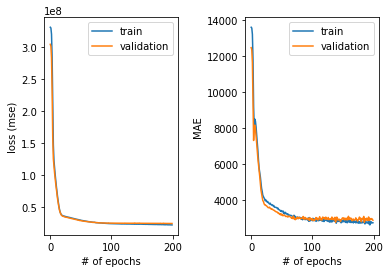

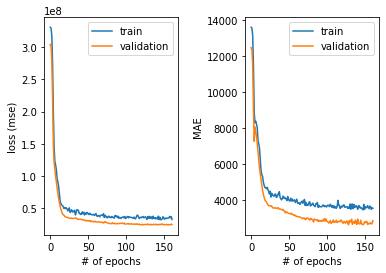

In [ ]:
# EXERCISE 8 - Regularization: dropout

# 1. In the design_model_dropout() method, after the hidden layer with 24 
# neurons, add another dropout method as an instance of tensorflow.keras.layers.Dropout 
# with the dropout rate set to 0.3.

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

### model.py
tf.random.set_seed(42) #for reproducibility of result we always use the same seed for random number generator

# dataset = pd.read_csv("insurance.csv") #read the dataset

def fit_model(model, f_train, l_train, learning_rate, num_epochs):
    #train the model on the training data
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
    history = model.fit(features_train, labels_train, epochs=num_epochs, batch_size= 16, verbose=0, validation_split = 0.2, callbacks = [es])
    return history

features = dataset.iloc[:,0:6] #choose first 7 columns as features
labels = dataset.iloc[:,-1] #choose the final column for prediction

features = pd.get_dummies(features) #one hot encoding for categorical variables
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)

#standardize
ct = ColumnTransformer([('standardize', StandardScaler(), ['age', 'bmi', 'children'])], remainder='passthrough')
features_train = ct.fit_transform(features_train) #gives numpy arrays
features_test = ct.transform(features_test) #gives numpy arrays

### insurance_tuning.py
def design_model_dropout(X, learning_rate):
    model = Sequential(name="my_first_model")
    input = tf.keras.Input(shape=(X.shape[1],))
    model.add(input)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(24, activation='relu'))
    #------your code here!------
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model

def design_model_no_dropout(X, learning_rate):
    model = Sequential(name="my_first_model")
    input = layers.InputLayer(input_shape=(X.shape[1],))
    model.add(input)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model
    
#using the early stopping in fit_model
learning_rate = 0.001
num_epochs = 200
#train the model without dropout
history1 = fit_model(design_model_no_dropout(features_train, learning_rate), features_train, labels_train, learning_rate, num_epochs)
#train the model with dropout
history2 = fit_model(design_model_dropout(features_train, learning_rate), features_train, labels_train, learning_rate, num_epochs)

### plot.py
def plot(history, path):
  #plotting
  fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.5}) 
  (ax1, ax2) = axs
  ax1.plot(history.history['loss'], label='train')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.legend(loc="upper right")
  ax1.set_xlabel("# of epochs")
  ax1.set_ylabel("loss (mse)")

  ax2.plot(history.history['mae'], label='train')
  ax2.plot(history.history['val_mae'], label='validation')
  ax2.legend(loc="upper right")
  ax2.set_xlabel("# of epochs")
  ax2.set_ylabel("MAE")

  plt.savefig(path)

plt.savefig('/content/drive/My Drive/Colab/Insurance/no_dropout.png')
plt.savefig('/content/drive/My Drive/Colab/Insurance/with_dropout.png')

plot(history1, '/content/drive/My Drive/Colab/Insurance/no_dropout.png')

plot(history2, '/content/drive/My Drive/Colab/Insurance/with_dropout.png')

